## 1. Creating a toy multi-class dataset

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

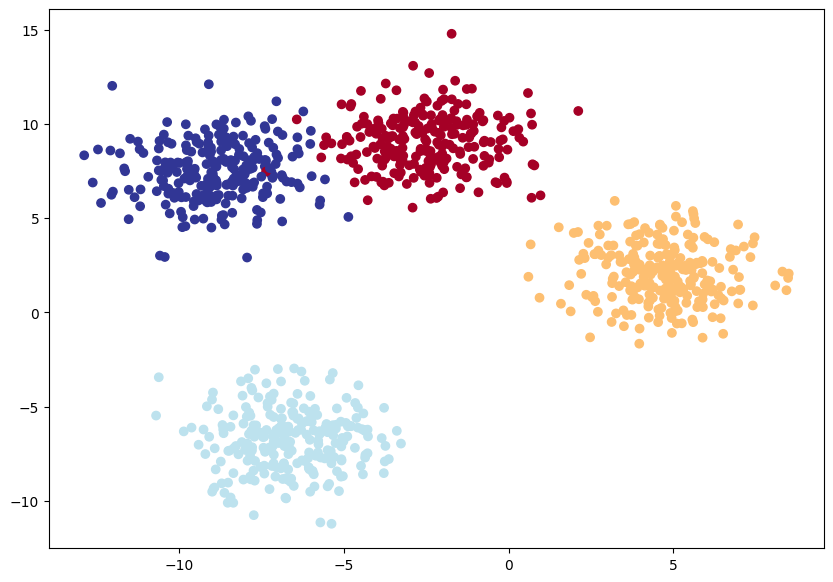

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data

X_blob, y_blob = make_blobs(
	n_samples=1000,
	n_features=NUM_FEATURES,
	centers=NUM_CLASSES,
	cluster_std=1.5,
	random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy( X_blob).type( torch.float)
y_blob = torch.from_numpy( y_blob).type( torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split( X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure( figsize=( 10, 7))
plt.scatter( X_blob[ :, 0], X_blob[ :, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## 2. Building a multi-class classification model

In [4]:
class BlobModel( nn.Module):
	def __init__( self, input_features, output_features, hidden_units=8):
		"""Initialize multi-class classification neural network model.

		Args:
			input_features (int): Number of input features to the model
			output_features (int): Number of output features (number of output classes)
			hidden_units (int): Number of hidden units between layers, default 8

		Returns:

		Example:
		"""
		super().__init__()

		self.linear_layer_stack = nn.Sequential(
			nn.Linear( in_features=input_features, out_features=hidden_units),
			nn.ReLU(),
			nn.Linear( in_features=hidden_units, out_features=hidden_units),
			nn.ReLU(),
			nn.Linear( in_features=hidden_units, out_features=output_features)
		)

	def forward( self, x):
		return self.linear_layer_stack( x)
	
# Create an instance
model_0 = BlobModel(
	input_features=2,
	output_features=4,
	hidden_units=8
).to( device)

model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 3. Create a loss function and optimizer

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD( params=model_0.parameters(), lr=0.1)

## 4. Getting prediction probabilities

logits (raw output of the model) -> probability (use `torch.softmax`) -> label (use `torch.argmax`)

In [6]:
model_0.eval()
with torch.inference_mode():
	y_logits = model_0( X_blob_test.to( device))

y_logits[ :10]

tensor([[ 1.2940e+00,  2.5647e-01, -4.4699e-01, -8.3471e-01],
        [ 1.2427e+00,  1.3760e-03, -8.8751e-01, -5.9267e-01],
        [ 6.7770e-01,  1.8753e-01, -2.9019e-01, -7.1202e-01],
        [ 7.0667e-01,  2.1249e-01, -9.0146e-02, -6.0056e-01],
        [ 2.0600e+00,  2.0877e-01, -1.1434e+00, -1.0095e+00],
        [ 1.3681e+00, -2.0780e-02, -1.0350e+00, -6.4037e-01],
        [ 6.7187e-01,  2.1534e-01, -2.7532e-01, -7.5754e-01],
        [ 1.7774e+00,  1.4411e-01, -1.0328e+00, -8.4249e-01],
        [ 7.2182e-01,  1.5200e-01, -3.4963e-01, -6.6983e-01],
        [ 1.8520e+00,  1.6618e-01, -1.0531e+00, -8.9283e-01]], device='cuda:0')

In [7]:
y_blob_test[ :10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [8]:
y_pred_probs = torch.softmax( y_logits, dim=1)

print( y_logits[ :5])
print( y_pred_probs[ :5])

tensor([[ 1.2940e+00,  2.5647e-01, -4.4699e-01, -8.3471e-01],
        [ 1.2427e+00,  1.3760e-03, -8.8751e-01, -5.9267e-01],
        [ 6.7770e-01,  1.8753e-01, -2.9019e-01, -7.1202e-01],
        [ 7.0667e-01,  2.1249e-01, -9.0146e-02, -6.0056e-01],
        [ 2.0600e+00,  2.0877e-01, -1.1434e+00, -1.0095e+00]], device='cuda:0')
tensor([[0.6065, 0.2149, 0.1064, 0.0722],
        [0.6380, 0.1844, 0.0758, 0.1018],
        [0.4461, 0.2733, 0.1695, 0.1111],
        [0.4289, 0.2617, 0.1933, 0.1161],
        [0.8038, 0.1262, 0.0327, 0.0373]], device='cuda:0')


In [9]:
y_preds = torch.argmax( y_pred_probs, dim=1)

y_preds[ :10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [10]:
# calculate accuracy
def accuracy_fn( y_true, y_pred):
	correct = torch.eq( y_true, y_pred).sum().item()
	acc = ( correct / len( y_pred)) * 100
	return acc

## 5. Creating a training and testing loop

In [11]:
# fit the model to the data

torch.manual_seed( RANDOM_SEED)
torch.cuda.manual_seed( RANDOM_SEED)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to( device), y_blob_train.to( device)
X_blob_test, y_blob_test = X_blob_test.to( device), y_blob_test.to( device)

for epoch in range( epochs):
	### Training
	model_0.train()

	y_logits = model_0( X_blob_train)
	y_pred = torch.softmax( y_logits, dim=1).argmax( dim=1)

	loss = loss_fn( y_logits, y_blob_train)
	acc = accuracy_fn( y_blob_train, y_pred)

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	### Testing
	model_0.eval()

	with torch.inference_mode():
		test_logits = model_0( X_blob_test)
		test_pred = torch.softmax( test_logits, dim=1).argmax( dim=1)

		test_loss = loss_fn( test_logits, y_blob_test)
		test_acc = accuracy_fn( y_blob_test, test_pred)

	if epoch % 10 == 0:
		print( f"Epoch: { epoch} | Loss: { loss:.4f}, Acc: { acc:.2f}% | Test Loss: { test_loss:.4f}, Test Acc: { test_acc:.2f}%")


Epoch: 0 | Loss: 1.4423, Acc: 25.12% | Test Loss: 1.3462, Test Acc: 24.50%
Epoch: 10 | Loss: 0.7282, Acc: 74.25% | Test Loss: 0.6867, Test Acc: 73.00%
Epoch: 20 | Loss: 0.4146, Acc: 98.25% | Test Loss: 0.4033, Test Acc: 100.00%
Epoch: 30 | Loss: 0.2616, Acc: 99.00% | Test Loss: 0.2443, Test Acc: 99.50%
Epoch: 40 | Loss: 0.1266, Acc: 99.12% | Test Loss: 0.1079, Test Acc: 99.50%
Epoch: 50 | Loss: 0.0742, Acc: 99.12% | Test Loss: 0.0601, Test Acc: 99.50%
Epoch: 60 | Loss: 0.0557, Acc: 99.25% | Test Loss: 0.0434, Test Acc: 99.50%
Epoch: 70 | Loss: 0.0467, Acc: 99.25% | Test Loss: 0.0352, Test Acc: 99.50%
Epoch: 80 | Loss: 0.0414, Acc: 99.25% | Test Loss: 0.0303, Test Acc: 99.50%
Epoch: 90 | Loss: 0.0379, Acc: 99.25% | Test Loss: 0.0270, Test Acc: 99.50%


## 6. Evaluation

In [12]:
model_0.eval()

with torch.inference_mode():
	y_logits = model_0( X_blob_test)

y_logits[ :10]

tensor([[ 2.7771,  8.2274, -1.4515, -8.8986],
        [ 2.4910, -8.2649, -4.0926,  7.3125],
        [-3.2417, -0.6465,  5.3211, -2.0946],
        [ 0.9384,  5.1956,  0.0594, -5.6570],
        [ 7.3840,  3.1639, -6.3316, -4.5344],
        [ 2.8010, -9.8801, -4.7926,  8.7751],
        [-3.4043, -0.6723,  5.5644, -2.1897],
        [ 6.6643, -0.0917, -5.8822, -1.2786],
        [-3.2552, -0.6743,  5.3418, -2.0792],
        [ 6.8255,  1.1266, -5.9695, -2.4503]], device='cuda:0')

In [13]:
y_pred_probs = torch.softmax( y_logits, dim=1)

y_pred_probs[ :10]

tensor([[4.2762e-03, 9.9566e-01, 6.2318e-05, 3.6340e-08],
        [7.9903e-03, 1.7035e-07, 1.1050e-05, 9.9200e-01],
        [1.9046e-04, 2.5518e-03, 9.9666e-01, 5.9978e-04],
        [1.3883e-02, 9.8033e-01, 5.7639e-03, 1.8972e-05],
        [9.8551e-01, 1.4484e-02, 1.0890e-06, 6.5699e-06],
        [2.5374e-03, 7.8898e-09, 1.2780e-06, 9.9746e-01],
        [1.2702e-04, 1.9515e-03, 9.9749e-01, 4.2793e-04],
        [9.9848e-01, 1.1621e-03, 3.5522e-06, 3.5464e-04],
        [1.8408e-04, 2.4315e-03, 9.9679e-01, 5.9665e-04],
        [9.9657e-01, 3.3381e-03, 2.7649e-06, 9.3339e-05]], device='cuda:0')

In [14]:
y_preds = torch.argmax( y_pred_probs, dim=1)

y_preds[ :10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

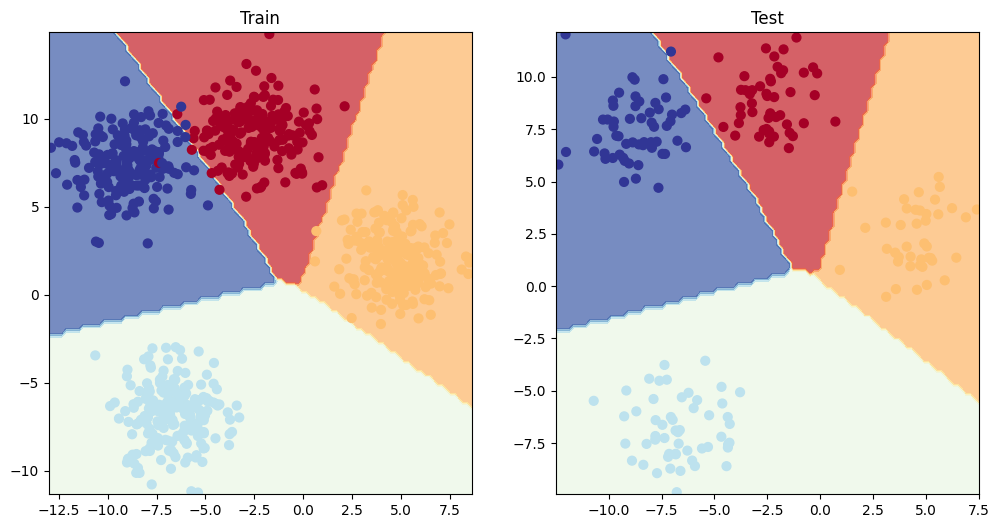

In [15]:
from helper_functions import plot_decision_boundary

plt.figure( figsize=( 12, 6))

plt.subplot( 1, 2, 1)
plt.title( "Train")
plot_decision_boundary( model_0, X_blob_train, y_blob_train)

plt.subplot( 1, 2, 2)
plt.title( "Test")
plot_decision_boundary( model_0, X_blob_test, y_blob_test)

## More classification metrics

- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [17]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy( task="multiclass", num_classes=4).to( device)

torchmetric_accuracy( y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')